In [1]:
import itertools
import numpy as np
import numpy.random as npr
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import colors
from matplotlib import gridspec
import matplotlib

import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D  

import scipy.io
from scipy.io import loadmat
from scipy.io import savemat
from scipy import stats
from scipy.special import softmax
from sklearn.metrics import log_loss
import pickle
import copy

%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.family':'Arial'})

In [2]:
subjectNames = ['sam','tabitha','chloe','blanche','b01','b02','b03','b04','b05','b06','b07','b08','b09','b10']

numSubjects = len(subjectNames)

stateNames = ['Persist','Preferred','Random','Avoid']
historyNames = ['(0,0)','(1,0)','(0,1)','(1,1)']

speciesList = np.array([0,0,0,0,1,1,1,1,1,2,2,2,2,2])

speciesColor = ['#fb8072','#8dd3c7','#74add1']
speciesNames = ['monkey','human','human2']

def getPM(N):
    if N == 1:
        return 1
    elif N > 1:
        x = np.zeros([N])
        x[0] = 1
        for i in np.arange(1,N):
            x[i] = -1 * x[i-1]
        return x

######################################
    
analysis = []
data = []
data0 = []


for i in range(numSubjects):
    with open('analysis/'+subjectNames[i]+'.pickle', 'rb') as f:
        [A] = pickle.load(f)
    analysis.append(A)
    with open('data/'+subjectNames[i]+'.pickle', 'rb') as f:
        [D] = pickle.load(f)
    data.append(D)
    data0.append(D)
    

categoryNames = ['block length',
                 'Perseveration',
                 'Random search',
                 'Rule random, \n Exploration',
                 'Rule favored, \n Exploration',
                 'Rule preferred, \n No exploration',
                 'Rule persist, \n No exploration']

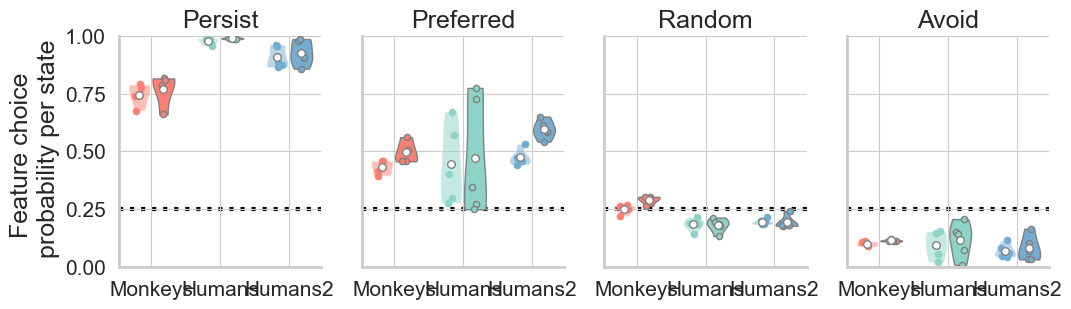

In [11]:
pc_S_mdl = np.zeros([numSubjects,4])
pc_S_emp = np.zeros([numSubjects,4])

for i in range(numSubjects):
    pc_S_mdl[i,:] = analysis[i]['choiceStats']['pc_S_mdl']
    pc_S_emp[i,:] = analysis[i]['choiceStats']['pc_S_emp']
# print(pc_S_emp[0,:])

vLoc = [0,2,4]
vpWidth = 0.7

fig, ax = plt.subplots(ncols=4,nrows=1,sharex=True,sharey=True,figsize=(4*3,3))

for k in range(4): # states
    for spInd in range(3): # monkey and 2 human datasets
        for src in range(2):
            if src == 0:
                pc = pc_S_mdl
            else:
                pc = pc_S_emp

            data1 = pc[np.where(speciesList == spInd)[0],k]
            x1 = vLoc[spInd]-vpWidth/2 + 2*src*(vpWidth/2)
            vp1 = ax[k].violinplot(data1,[x1],showextrema=False,widths=0.9*vpWidth)
            for pc in vp1['bodies']:
                pc.set_facecolor(speciesColor[spInd])
                if src == 0:
                    pc.set_alpha(0.5)
                else:
                    pc.set_edgecolor('gray')
                    pc.set_alpha(1)

            x = npr.rand(np.where(speciesList == spInd)[0].size) * (vpWidth) * (0.2)
            pm = getPM(x.shape[0])
            x = np.multiply(x,pm) + x1
            if src == 0:
                ax[k].scatter(x,data1,s=20,color=speciesColor[spInd])
            else:
                ax[k].scatter(x,data1,s=20,color=speciesColor[spInd], edgecolor='gray')

            ax[k].scatter(x1,np.mean(data1),color='white',s=30,edgecolors='gray')

    #####################
    
    xlim = ax[k].get_xlim()
    ax[k].hlines(0.25,xmin=xlim[0],xmax=xlim[1],color='black',linestyle='dotted',zorder=0,linewidth=3)
    ax[k].set_xlim(xlim)
    
    ax[k].set_title(stateNames[k],fontsize=18)
    if k == 0:
        # ax[k].set_ylabel('$P ( c_t = 1 \mid z_t )$',fontsize=20)
        ax[k].set_ylabel('Feature choice \n probability per state',fontsize=18)
    #####################
    
    ax[k].set_ylim([0,1])
    ax[k].set_xticks(vLoc)
    ax[k].set_yticks([0,0.25,0.5,0.75,1])
    ax[k].set_xticklabels(['Monkeys','Humans','Humans2'],fontsize=20)
    
    ax[k].tick_params(axis='both',labelsize=15,direction='out',width=2, length=6)
#     ax[k].tick_params(axis='x',length=5)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[k].spines[axis].set_linewidth(2)

    ax[k].spines['right'].set_visible(False)
    ax[k].spines['top'].set_visible(False)
    
    ax[k].set_axisbelow(True)
    # ax[k].grid(which='major', axis='y')
# plt.savefig('meanChoiceProb.eps', format='eps')

In [5]:
pDown = np.zeros((numSubjects))
for i in range(numSubjects):
    data=analysis[i]['categoryAnalysis']['infProcsUp']#[0]
    dnCnt = 0
    totCnt = 0

    for j in range(data.shape[0]):            
        if data[j,0] < 3: # feature was not in avoid
            if data[j,2] == 1: # feature belongs to the same dimension as the (other) feature that transitioned up
                dnCnt += int(data[j,0] < data[j,1]) # feature transitioned down
                totCnt += 1

    if totCnt == 0 and dnCnt ==0:
        pDown[i] = np.nan
    else:
        pDown[i] = dnCnt/totCnt


In [6]:
pUp = np.zeros((numSubjects))
for i in range(numSubjects):
    data=analysis[i]['categoryAnalysis']['infProcsDown']
    upCnt = 0
    totCnt = 0

    for j in range(data.shape[0]):            

        if data[j,0] > 0: # feature was not in persist on previous trial
            if data[j,2] == 1: # feature belongs to the same dimension as the (other) feature that transitioned down
                upCnt += int(data[j,0] > data[j,1]) # this feature transitioned up
                totCnt += 1

    if totCnt == 0 and upCnt ==0:
        pUp[i] = np.nan
    else:
        pUp[i] = upCnt/totCnt


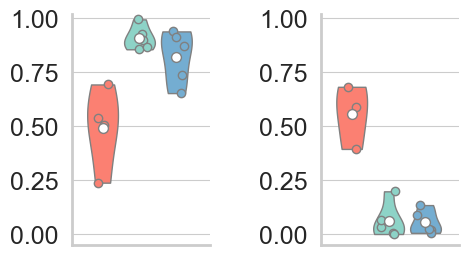

In [7]:
# speciesColor = ['#fb8072','#8dd3c7']

fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(5,3))

vpWidth = 0.5

for i in np.unique(speciesList):
    idx = np.where(np.array(speciesList) == i)[0]
    for j in range(2):
        if j == 0:
            data = pDown[idx]
        else:
            data = pUp[idx]
            
        data = np.delete(data, np.nonzero(np.isnan(data))[0], axis=0)
        vp = ax[j].violinplot(data,[i*0.6],showextrema=False,widths=vpWidth)

        x = npr.rand(data.shape[0]) * (vpWidth) * (0.3)
        pm = getPM(data.shape[0])
        x = np.multiply(x,pm)+i*0.6#-0.1#i-0.1 #np.multiply(x,pm) + i

        ax[j].scatter(x,data,color=speciesColor[i],edgecolors='gray')

        for pc in vp['bodies']:
            pc.set_facecolor(speciesColor[i])
            pc.set_edgecolor('gray')
            pc.set_alpha(1)

        ax[j].scatter(i*0.6,np.mean(data),color='white',s=50,edgecolors='gray')  

for j in range(2):
    ax[j].set_ylim([-0.05,1.02])
    ax[j].set_xlim([-0.5,1.75])
    ax[j].set_xticks([])
    # ax.set_xticklabels(['Overall','Intra-dimensional'],fontsize=18)
    # ax.set_xticklabels(['Overall','Intra-dimensional'],fontsize=18)


    ax[j].set_yticks([0,0.25,0.5,0.75,1])
#     ax[j].set_ylabel('Prob. lowering state of chosen feature \n when making Preferred->persist transition',fontsize=20)

    ax[j].tick_params(axis='both',labelsize= 18,direction='out',width=2, length=6)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[j].spines[axis].set_linewidth(2)

    ax[j].spines['right'].set_visible(False)
    ax[j].spines['top'].set_visible(False)

    plt.subplots_adjust(wspace=0.8, 
                        hspace=0.0)
# plt.savefig('infUpDown.eps', format='eps')

In [8]:
delta_Pc_NC_min = np.zeros((numSubjects))
delta_Pc_NC_plus = np.zeros((numSubjects))

for i in range(numSubjects):
    delta_Pc_NC_min[i] = analysis[i]['choicePreviousStateStats']['pc_HS0_mdl'][0,1]-analysis[i]['choicePreviousStateStats']['pc_S0_mdl'][1]
    delta_Pc_NC_plus[i] = analysis[i]['choicePreviousStateStats']['pc_HS0_mdl'][1,1]-analysis[i]['choicePreviousStateStats']['pc_S0_mdl'][1]



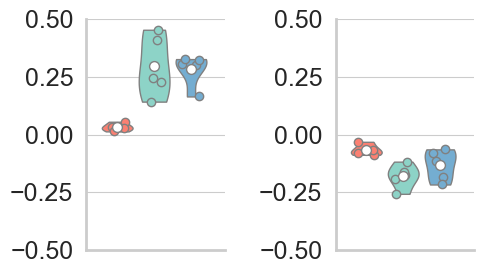

In [9]:
# speciesColor = ['#fb8072','#8dd3c7']

fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(5,3))

vpWidth = 0.5

for i in np.unique(speciesList):
    idx = np.where(np.array(speciesList) == i)[0]
    for j in range(2):
        if j == 0:
            data = delta_Pc_NC_min[idx]
        else:
            data = delta_Pc_NC_plus[idx]
            
        data = np.delete(data, np.nonzero(np.isnan(data))[0], axis=0)
        vp = ax[j].violinplot(data,[i*0.6],showextrema=False,widths=vpWidth)

        x = npr.rand(data.shape[0]) * (vpWidth) * (0.3)
        pm = getPM(data.shape[0])
        x = np.multiply(x,pm)+i*0.6#-0.1#i-0.1 #np.multiply(x,pm) + i

        ax[j].scatter(x,data,color=speciesColor[i],edgecolors='gray')

        for pc in vp['bodies']:
            pc.set_facecolor(speciesColor[i])
            pc.set_edgecolor('gray')
            pc.set_alpha(1)

        ax[j].scatter(i*0.6,np.mean(data),color='white',s=50,edgecolors='gray')  

for j in range(2):
    ax[j].set_ylim([-0.5,0.5])
    ax[j].set_xlim([-0.5,1.75])
    ax[j].set_xticks([])
    # ax.set_xticklabels(['Overall','Intra-dimensional'],fontsize=18)
    # ax.set_xticklabels(['Overall','Intra-dimensional'],fontsize=18)


    ax[j].set_yticks([-0.5, -0.25, 0,0.25,0.5])
#     ax[j].set_ylabel('Prob. lowering state of chosen feature \n when making Preferred->persist transition',fontsize=20)

    ax[j].tick_params(axis='both',labelsize= 18,direction='out',width=2, length=6)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[j].spines[axis].set_linewidth(2)

    ax[j].spines['right'].set_visible(False)
    ax[j].spines['top'].set_visible(False)

    plt.subplots_adjust(wspace=0.8, 
                        hspace=0.0)
# plt.savefig('deltInf.eps', format='eps')

# Supp

In [14]:
pc_HS = np.zeros([numSubjects,4,4,2])

for i in range(numSubjects):
    
    pc_HS[i,:,:,0] = analysis[i]['choiceStats']['pc_HS_mdl']
    pc_HS[i,:,:,1] = analysis[i]['choiceStats']['pc_HS_emp']
pc_HS[np.isnan(pc_HS)] = 0


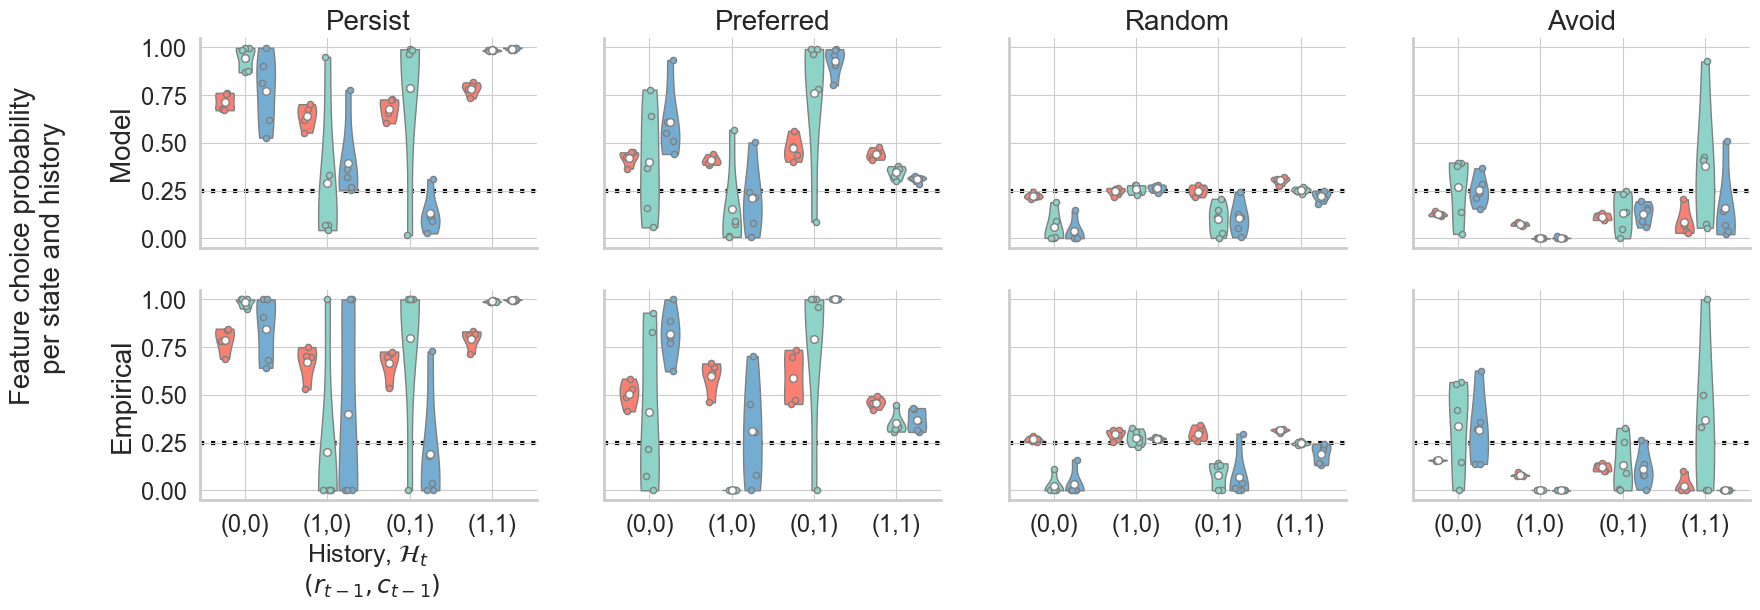

In [19]:
historyNames = ['(0,0)','(1,0)','(0,1)','(1,1)']

vLoc = [0,3,6,9]
vpWidth = 0.75

fig, ax = plt.subplots(ncols=4,nrows=2,sharex=True,sharey=True,figsize=(4*5,6))

# fig.text(0.52, -0.15, '$\mathcal{H}_t$, $(r_{t-1},c_{t-1})$', ha='center', size=20)
fig.text(0.03, 0.54, 'Feature choice probability \n    per state and history', va='center', rotation='vertical', size=20)

for  i in range(2): # model, empirical
    for k in range(4): # state
        for h in range(4): # history
            for s in np.unique(speciesList):
                idx = np.where(np.array(speciesList) == s)[0]

                # monkey
                data1 = pc_HS[idx,h,k,i]
                x1 = vLoc[h]-vpWidth + s*(vpWidth)
                vp1 = ax[i,k].violinplot(data1,[x1],showextrema=False,widths=0.9*vpWidth)
                for pc in vp1['bodies']:
                    pc.set_facecolor(speciesColor[s])#'#fb8072') CHANGE
                    pc.set_edgecolor('gray')
                    pc.set_alpha(1)

                x = npr.rand(len(idx)) * (vpWidth) * (0.2)
                pm = getPM(x.shape[0])
                x = np.multiply(x,pm) + x1
                ax[i,k].scatter(x,data1,s=20,color=speciesColor[s],edgecolors='gray')
                ax[i,k].scatter(x1,np.mean(data1),color='white',s=30,edgecolors='gray')

        ####################

        xlim = ax[i,k].get_xlim()
        ax[i,k].hlines(0.25,xmin=xlim[0],xmax=xlim[1],color='black',linestyle='dotted',zorder=0,linewidth=3)
        ax[i,k].set_xlim(xlim)
        
        if i == 0:
            ax[i,k].set_title(stateNames[k],fontsize=20)
        if i == 0 and k == 0:
            ax[i,k].set_ylabel('Model',fontsize=20)
        #if k == 0:
        #    ax[i,k].set_ylabel('$P ( c_t = 1 \mid \mathcal{H}_t, z_t )$',fontsize=20)
        if i == 1 and k == 0:
            ax[i,k].set_xlabel('History, $\mathcal{H}_t$ \n $(r_{t-1},c_{t-1})$',fontsize=18)
            ax[i,k].set_ylabel('Empirical',fontsize=20)

        #####################

        ax[i,k].set_ylim([-0.05,1.05])
        ax[i,k].set_xticks(vLoc)
        ax[i,k].set_yticks([0,0.25,0.5,0.75,1])
        ax[i,k].set_xticklabels(historyNames)

        ax[i,k].tick_params(axis='both',labelsize= 17,direction='out',width=2, length=6)
#         ax[i,k].tick_params(axis='x',length=5)
        # change all spines
        for axis in ['top','bottom','left','right']:
            ax[i,k].spines[axis].set_linewidth(2)

        ax[i,k].spines['right'].set_visible(False)
        ax[i,k].spines['top'].set_visible(False)

        ax[i,k].set_axisbelow(True)
        # ax[i,k].grid(which='major', axis='both')
# plt.savefig('choiceProb.eps', format='eps')

In [43]:
# Plot transition matrix

def plotTransitionMatrix(pz_HS, ax):
    vLoc = [0,3,6,9]
    vpWidth = 0.75
    fig.text(0.52, 0.92, 'Next state', ha='center', size=20)
    fig.text(0.0, 0.5, 'Current state', va='center', rotation='vertical', size=20)
    # fig.text(0.52, 0.01, 'to state \n($z_{t}$)', ha='center', size=20)
    # fig.text(0.0, 0.5, 'from state \n   ($z_{t-1}$)', va='center', rotation='vertical', size=20)

    for s in range(4):
        for t in range(4):
            for h in range(4):
                for sp in np.unique(speciesList):
                    idx = np.where(np.array(speciesList) == sp)[0]

                    data1 = pz_HS[idx,t,h,s]
                    data1 = np.delete(data1, np.nonzero(np.isnan(data1))[0], axis=0)
                    if np.sum(np.isnan(data1)) > 0:
                        print(data1)
                        print('prob')
                    if data1.shape[0] > 0:
                        x1 = vLoc[h]-vpWidth + sp*vpWidth
                        vp1 = ax[s,t].violinplot(data1,[x1],showextrema=False,widths=0.9*vpWidth)
                        for pc in vp1['bodies']:
                            pc.set_facecolor(speciesColor[sp])
                            pc.set_edgecolor('gray')
                            pc.set_alpha(1)

                        x = npr.rand(data1.shape[0]) * (vpWidth) * (0.2)
                        pm = getPM(x.shape[0])
                        x = np.multiply(x,pm) + x1
                        ax[s,t].scatter(x,data1,s=20,color=speciesColor[sp],edgecolors='gray')

                        ax[s,t].scatter(x1,np.mean(data1),color='white',s=30,edgecolors='gray')

            ####################

            xlim = ax[s,t].get_xlim()
            # ax[s,t].hlines(0.25,xmin=xlim[0],xmax=xlim[1],color='red',linestyle='dotted',zorder=0,linewidth=2)
            ax[s,t].set_xlim(xlim)

            #
            if t == 0:
    #             ax[s,t].set_ylabel(stateNames[s],fontsize=16)
                ax[s,t].text(-8.5,0.25,stateNames[s],fontsize=16,rotation='vertical')


            if s == 0:
                ax[s,t].set_title(stateNames[t],fontsize=16)

            if s == 3 and t == 0:
    #             ax[s,t].set_ylabel('$P(z_t \mid \mathcal{H}_t, z_{t-1})$',fontsize=16)
                ax[s,t].set_ylabel('Transition probability given \n history and current state',fontsize=16)
                ax[s,t].set_xlabel('$\mathcal{H}_t$, $(r_{t-1},c_{t-1})$',fontsize=16)

            #####################

            ax[s,t].set_ylim([-0.05,1.05])
            ax[s,t].set_xticks(vLoc)
            ax[s,t].set_yticks([0,0.25,0.5,0.75,1])
            ax[s,t].set_xticklabels(historyNames)
            ax[s,t].tick_params(axis='both',labelsize= 15,direction='out',width=2, length=6)
    #         ax[s,t].tick_params(axis='x',length=5)
            # change all spines
            for axis in ['top','bottom','left','right']:
                ax[s,t].spines[axis].set_linewidth(2)

            ax[s,t].spines['right'].set_visible(False)
            ax[s,t].spines['top'].set_visible(False)

            ax[s,t].set_axisbelow(True)
            # ax[s,t].grid(which='major', axis='both')

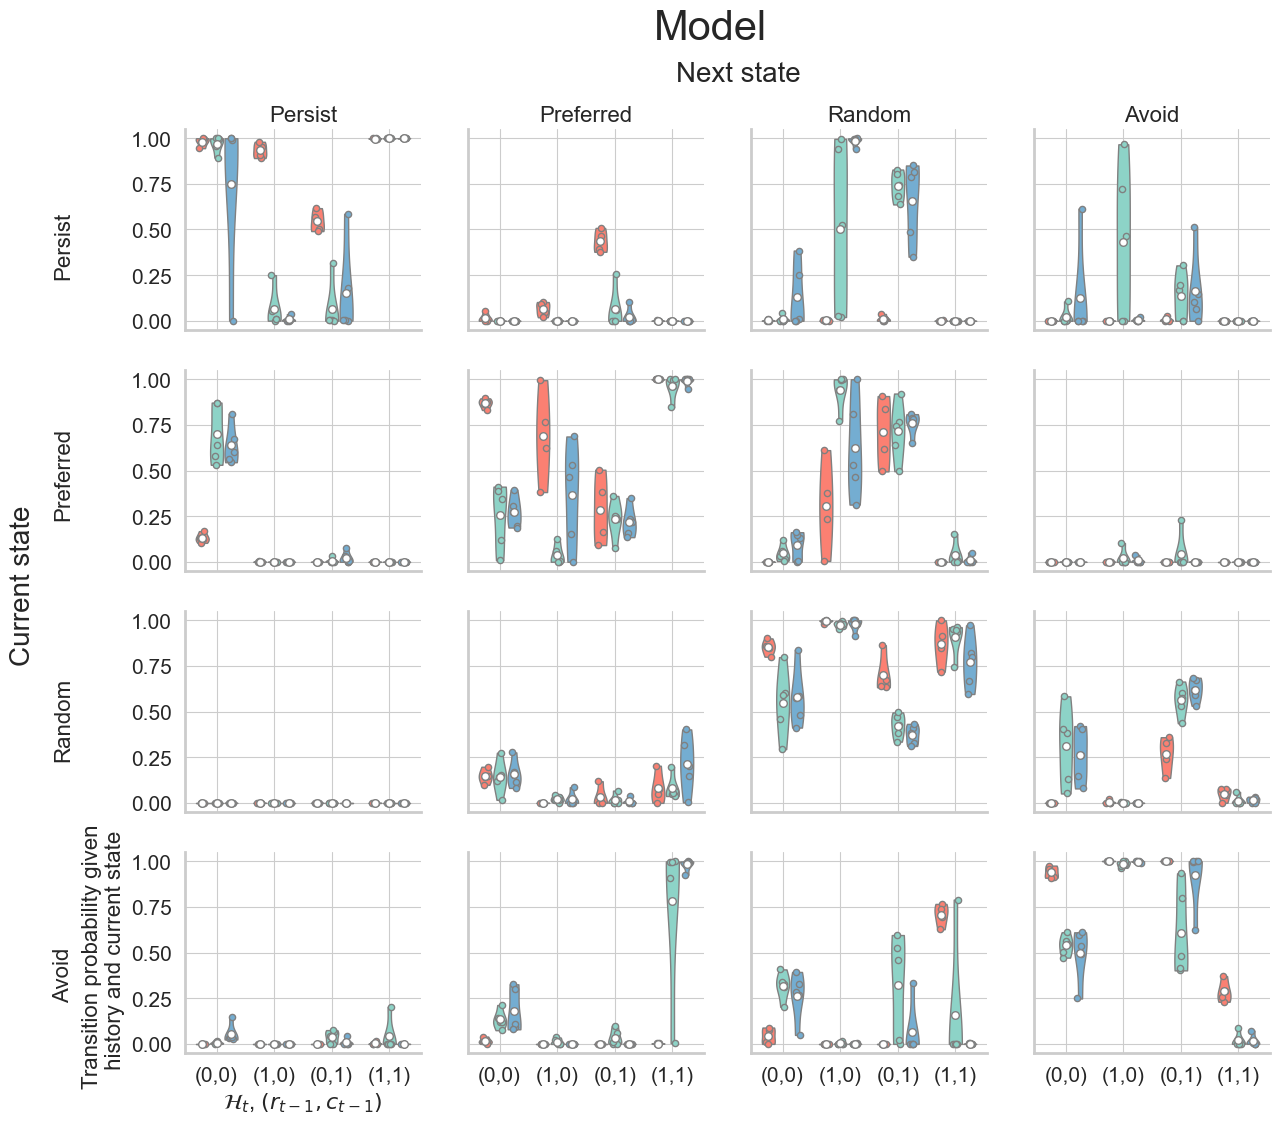

In [44]:
pz_HS_mdl = np.zeros([numSubjects,4,4,4])
for i in range(numSubjects):
    pz_HS_mdl[i] = analysis[i]['transitionStats']['pz_HS_mdl']

fig, ax = plt.subplots(ncols=4,nrows=4,sharex=True,sharey=True,figsize=(3.5*4,4*3))

fig.suptitle('Model',size=30,y=0.98)
plotTransitionMatrix(pz_HS_mdl, ax)

# plt.savefig('transProbMdl.eps', format='eps')

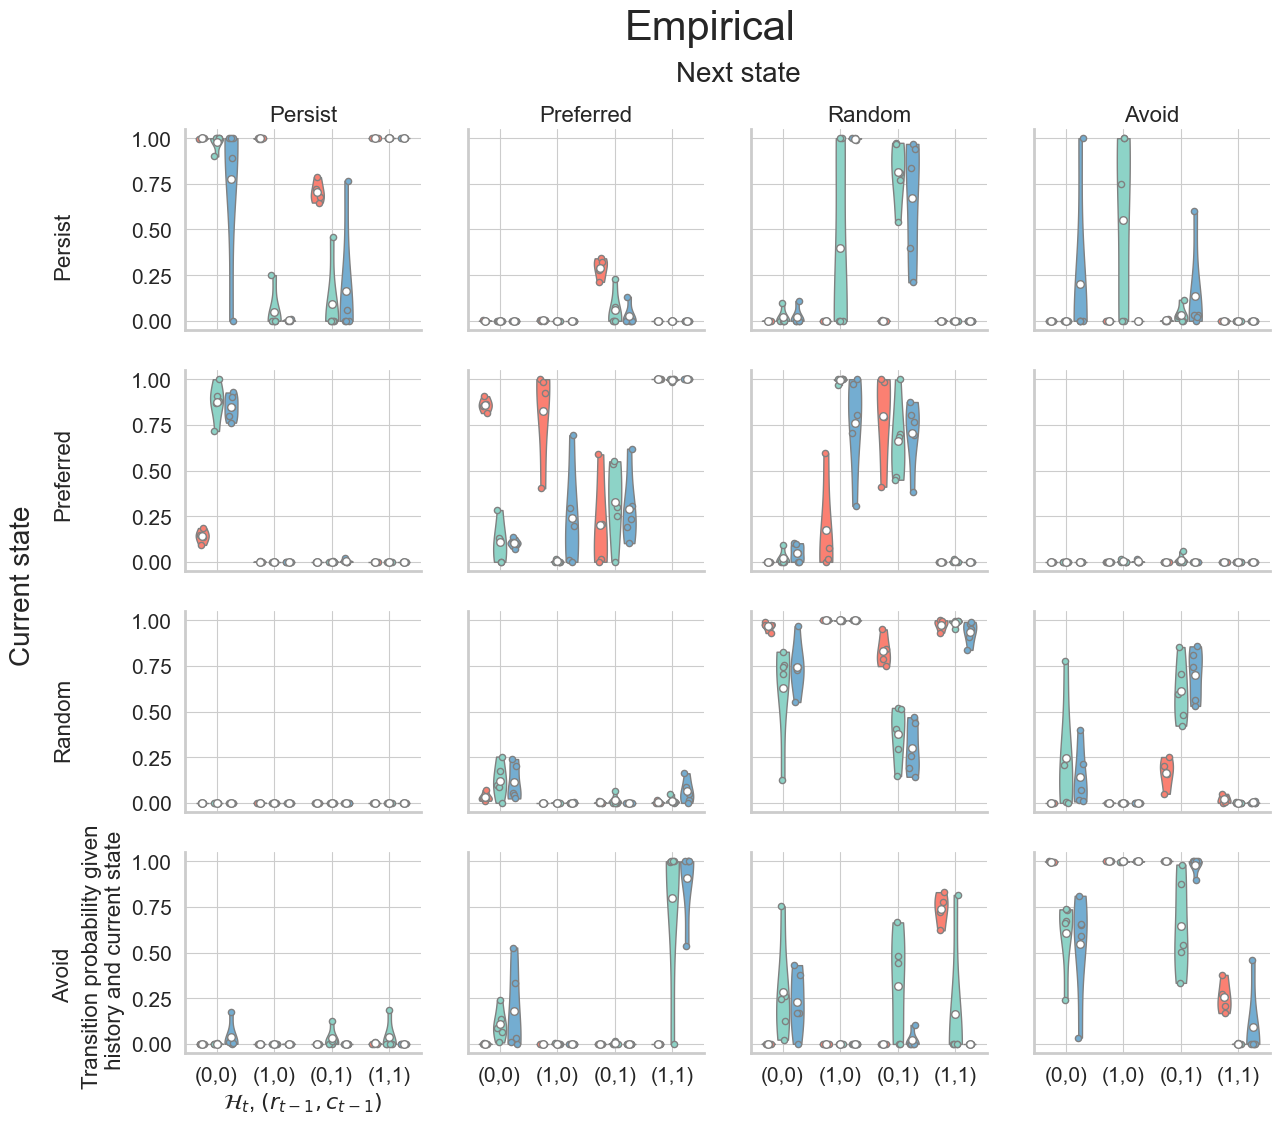

In [45]:
pz_HS_emp = np.zeros([numSubjects,4,4,4])
for i in range(numSubjects):
    pz_HS_emp[i] = analysis[i]['transitionStats']['pz_HS_emp']
# pz_HS_emp[np.isnan(pz_HS_emp)] = 0

fig, ax = plt.subplots(ncols=4,nrows=4,sharex=True,sharey=True,figsize=(3.5*4,4*3))

fig.suptitle('Empirical',size=30,y=0.98)

plotTransitionMatrix(pz_HS_emp, ax)

# plt.savefig('transProbExp.eps', format='eps')

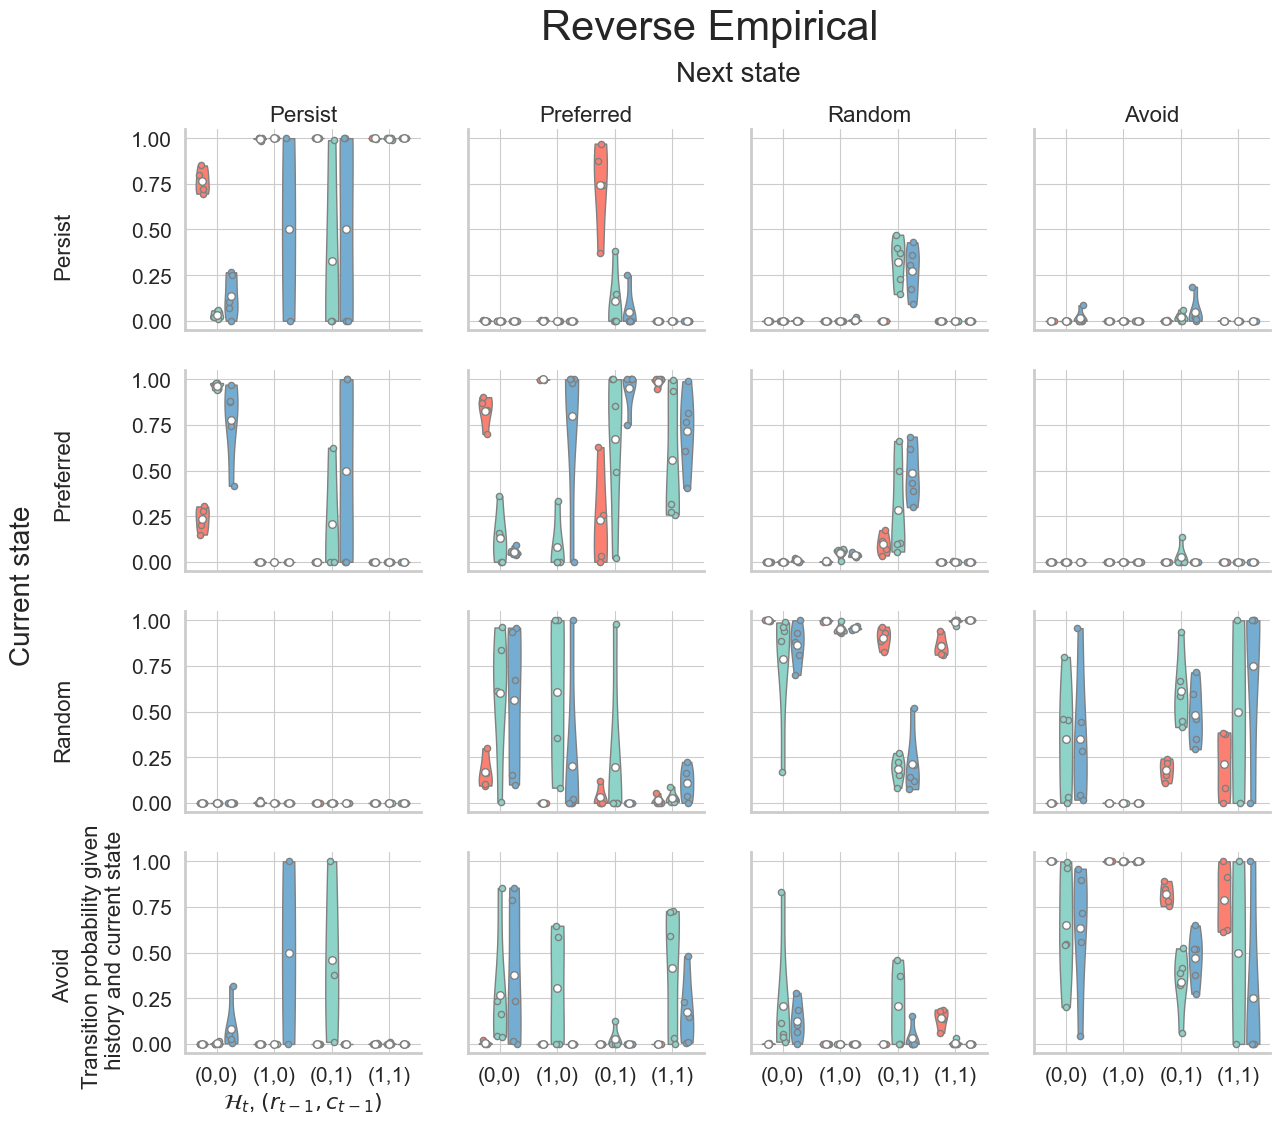

In [46]:
pS_Hz_emp = np.zeros([numSubjects,4,4,4])
for i in range(numSubjects):
    pS_Hz_emp[i] = analysis[i]['transitionStats']['pS_Hz_emp'][0]

fig, ax = plt.subplots(ncols=4,nrows=4,sharex=True,sharey=True,figsize=(3.5*4,4*3))

fig.suptitle('Reverse Empirical',size=30,y=0.98)
plotTransitionMatrix(pS_Hz_emp, ax)

# plt.savefig('revTransProbExp.eps', format='eps')

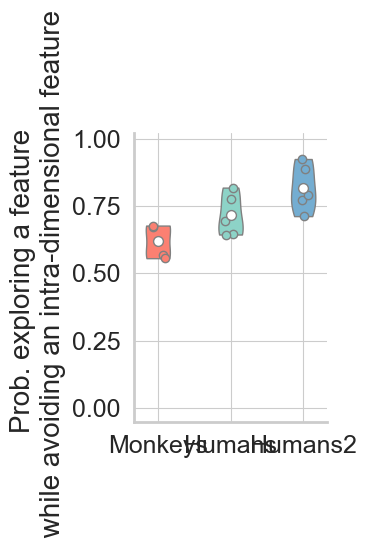

In [25]:
pExp_avoidIntraDim = np.zeros((numSubjects))
for i in range(numSubjects):
    pExp_avoidIntraDim[i] = analysis[i]['categoryAnalysis']['avoidAdjacent']

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(2*1.25,3*1.25))

vpWidth = 0.5

for i in np.unique(speciesList):
    idx = np.where(np.array(speciesList) == i)[0]
    data = pExp_avoidIntraDim[idx]
    vp = ax.violinplot(data,[i*1.5],showextrema=False,widths=vpWidth)

    x = npr.rand(data.shape[0]) * (vpWidth) * (0.3)
    pm = getPM(data.shape[0])
    x = np.multiply(x,pm)+i*1.5#-0.1#i-0.1 #np.multiply(x,pm) + i

    ax.scatter(x,data,color=speciesColor[i],edgecolors='gray')

    for pc in vp['bodies']:
        pc.set_facecolor(speciesColor[i])
        pc.set_edgecolor('gray')
        pc.set_alpha(1)

    ax.scatter(i*1.5,np.mean(data),color='white',s=50,edgecolors='gray')  

ax.set_ylim([-0.05,1.02])
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0,1.5,3.0])
ax.set_xticklabels(['Monkeys','Humans','Humans2'],fontsize=18)

ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_ylabel('Prob. exploring a feature \n while avoiding an intra-dimensional feature',fontsize=20)

ax.tick_params(axis='both',labelsize= 18,direction='out',width=2, length=6)
# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.subplots_adjust(wspace=0.3, 
#                     hspace=0.0) 
# plt.savefig('combRandAv.eps', format='eps')

In [49]:
pH_S = np.zeros([numSubjects,4,4])

for i in range(numSubjects):

    pH_S[i,:,:] = analysis[i]['choiceStats']['pH_S']



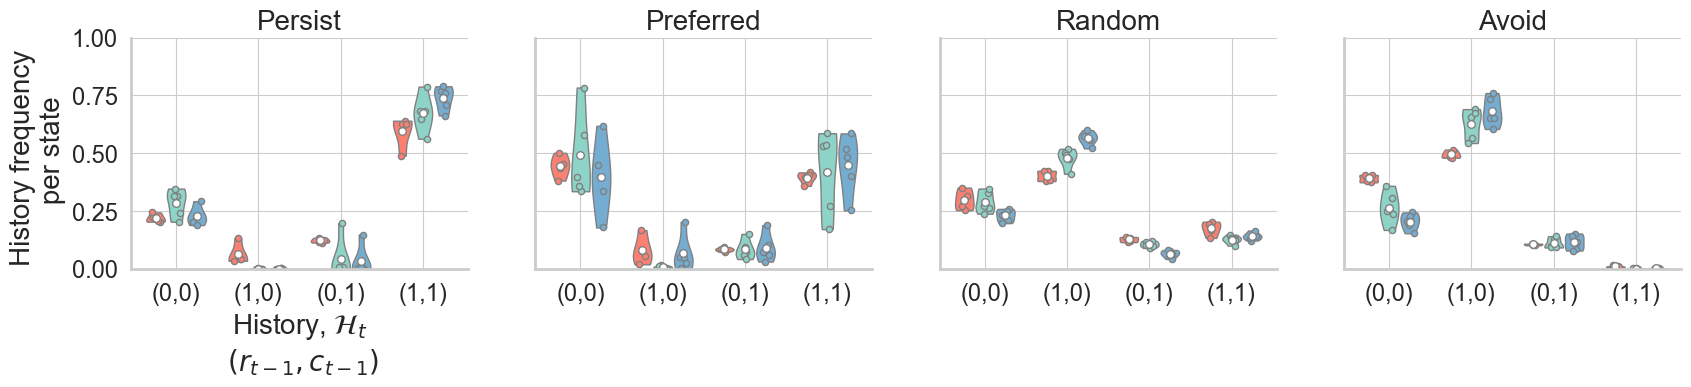

In [50]:
vLoc = [0,3,6,9]
vpWidth = 0.75

fig, ax = plt.subplots(ncols=4,nrows=1,sharex=True,sharey=True,figsize=(4*5,3))

# fig.text(0.52, -0.15, '$\mathcal{H}_t$, $(r_{t-1},c_{t-1})$', ha='center', size=20)

for k in range(4): # state
    for h in range(4): # history
        for s in np.unique(speciesList):
            idx = np.where(np.array(speciesList) == s)[0]

            data1 = pH_S[idx,h,k]
            x1 = vLoc[h]-vpWidth + s*vpWidth
            vp1 = ax[k].violinplot(data1,[x1],showextrema=False,widths=0.9*vpWidth)
            for pc in vp1['bodies']:
                pc.set_facecolor(speciesColor[s])
                pc.set_edgecolor('gray')
                pc.set_alpha(1)

            x = npr.rand(len(idx)) * (vpWidth) * (0.2)
            pm = getPM(x.shape[0])
            x = np.multiply(x,pm) + x1
            ax[k].scatter(x,data1,s=20,color=speciesColor[s],edgecolors='gray')

            ax[k].scatter(x1,np.mean(data1),color='white',s=30,edgecolors='gray')

    ####################
    
    xlim = ax[k].get_xlim()
    # ax[k].hlines(0.25,xmin=xlim[0],xmax=xlim[1],color='red',linestyle='dotted',zorder=0,linewidth=2)
    ax[k].set_xlim(xlim)
    
    ax[k].set_title(stateNames[k],fontsize=20)
    if k == 0:
        # ax[k].set_ylabel('$P ( \mathcal{H}_t \mid z_t )$',fontsize=20)
        ax[k].set_ylabel('History frequency \n per state', fontsize=20)
        ax[k].set_xlabel('History, $\mathcal{H}_t$ \n $(r_{t-1},c_{t-1})$',fontsize=20)
    #####################
    
    ax[k].set_ylim([0,1])
    ax[k].set_xticks(vLoc)
    ax[k].set_yticks([0,0.25,0.5,0.75,1])
    ax[k].set_xticklabels(historyNames)
    
    ax[k].tick_params(axis='both',labelsize= 17,direction='out',width=2, length = 6)
#     ax[k].tick_params(axis='x',length=5)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[k].spines[axis].set_linewidth(2)

    ax[k].spines['right'].set_visible(False)
    ax[k].spines['top'].set_visible(False)
    
    ax[k].set_axisbelow(True)
    # ax[k].grid(which='major', axis='both')
# plt.savefig('histFreq.eps', format='eps')

In [ ]:
# Strategy deviation of humans (dataset2 compared to dataset1)
# Indirect:
#   Persist
#       NC+ - Random/Avoid
#       NC- - Persist
#   Preferred
#       NC+ - Mostly Random/Avoid, little preferred

